# Recommender System - Tensor Flow

## 1. Prerequisites

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings


warnings.filterwarnings('ignore')
%matplotlib inline


import tensorflow as tf
import scipy
import scipy.io
import scipy.sparse as sp

from keras.layers import Input, Embedding, Flatten, Dot, Dense
from keras.models import Model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from helpers import load_data

DATA_TRAIN_PATH = "data/data_train.csv"
ratings = load_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = "data/sampleSubmission.csv"
samples = load_data(DATA_TEST_PATH)

number of items: 10000, number of users: 1000
number of items: 10000, number of users: 1000


In [42]:
from sklearn.model_selection import train_test_split
from helpers import convert_train


data, n_users, n_movies = convert_train(ratings)
train, test = train_test_split(data, test_size=0.1, random_state=42)

submission,_,_=convert_train(samples)


In [21]:
data.head()

,user_id,movie_id,rating
0,0,9,5
1,0,60,5
2,0,67,4
3,0,83,4
4,0,205,2


## 2. Creating a dot product model

In [22]:
movie_input = Input(shape=[1], name="Movies-Input")
movie_embedding = Embedding(n_movies+1, 5, name="Movies-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

prod = Dot(name="Dot-Product", axes=1)([movie_vec, user_vec])
model1 = Model([user_input, movie_input], prod)
model1.compile(loss = 'mse', optimizer = 'adam')


Epoch 1/150
1059256/1059256 [==============================] - 12s 11us/step - loss: 6.4708
Epoch 2/150
1059256/1059256 [==============================] - 10s 10us/step - loss: 1.0467
Epoch 3/150
1059256/1059256 [==============================] - 9s 9us/step - loss: 1.0165
Epoch 4/150
1059256/1059256 [==============================] - 10s 9us/step - loss: 1.0145
Epoch 5/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0138
Epoch 6/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0134
Epoch 7/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0126
Epoch 8/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0116
Epoch 9/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0103
Epoch 10/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0081
Epoch 11/150
1059256/1059256 [==============================] - 9s 8us/step - loss: 1.0054
Ep

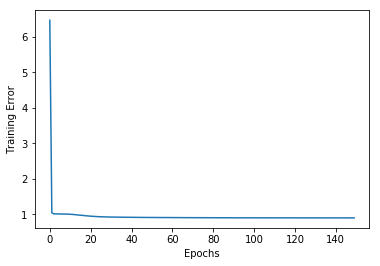

In [23]:
from keras.models import load_model

if os.path.exists('regression_model.h5'):
    model1 = load_model('regression_model.h5')
else:
    history = model1.fit([train.user_id, train.movie_id], train.rating, epochs=150,batch_size=200 ,verbose=1)
    model1.save('regression_model.h5')
    plt.plot(history.history['loss'])
    plt.xlabel("Epochs")
    plt.ylabel("Training Error")

In [85]:
scores = model1.evaluate([test.user_id, test.movie_id], test.rating)

predictions = model1.predict([test.user_id, test.movie_id])

print("Accuracy: %.2f%%" % (scores*100))

predictions_dot= model1.predict([submission.user_id, submission.movie_id])

117696/117696 [==============================] - 2s 14us/step
Accuracy: 100.92%


In [87]:
predictions_dot = np.array([a[0] for a in predictions_dot])
prediction_dot = np.rint(predictions_dot)

prediction_dot = np.where(prediction_dot < 0, 0, prediction_dot)
prediction_dot = np.where(prediction_dot > 5, 5, prediction_dot)



submission.drop('rating',axis = 1, inplace = True)
submission['rating'] = prediction_dot

[3. 3. 4. ... 2. 4. 4.]


In [83]:
print([submission.rating[i] for i in np.where(prediction_dot>5)])

[Series([], Name: rating, dtype: float32)]


In [88]:
from helpers import load_csv
export_csv = load_csv('data/prediction_dot_product',submission)